In [46]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs

In [47]:
L = 1.0  # domain length
T = 0.15  # end time
M = 2  # number of elements
p = 5  # degree of discretization
initial_data = InitialDataSine(1.0, 2*π/L)
source_term = nothing
conservation_law = burgers_equation(source_term=source_term,
    numerical_flux=EntropyConservativeNumericalFlux{BurgersFlux{1}}());
tol = 1.0e-6
dt_scale=0.01;

Conservation form

In [48]:
results_path = "../results/burgers_conservation_vs_split/conservation_form/"
reference_approximation = ReferenceApproximation(
    DGSEM(p), Line(), N_plot=50)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
form = StrongConservationForm()
strategy = Eager()
solver = Solver(conservation_law, spatial_discretization, form, strategy)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true);

In [49]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s - 2
dmd_analysis = DMDAnalysis(results_path, conservation_law, 
    spatial_discretization, r=r, tol=tol)
plotter = Plotter(spatial_discretization, string(results_path,"plots/"));

In [50]:
dt = dt_scale*(L/M)/(2*p+1)
n_t = floor(Int, T/dt)
u0 = initialize(initial_data, conservation_law, spatial_discretization)
ode_problem = semidiscretize(solver, u0, (0.0, T))
save_solution(u0, 0.0, results_path, 0)
sol_cons = solve(ode_problem, Tsit5(), adaptive=false, 
    dt=T/n_t, save_everystep=false,
    callback=save_callback(results_path, floor(Int, n_t/(n_s-1))))
save_solution(last(sol_cons.u), last(sol_cons.t), results_path, "final");

Conservation (initial/final/diff):
[-1.6653345369377348e-16][2.220446049250313e-16][3.885780586188048e-16]
Energy (initial/final/diff):
[0.49998164945973145][0.4990241398829575][-0.0009575095767739294]
Max amplification: (1.7148236292172356, 9)


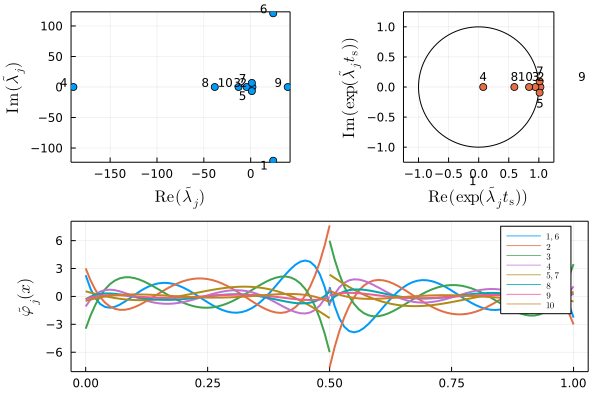

In [51]:
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)
dmd_results = analyze(dmd_analysis)
println("Max amplification: ", findmax(abs.(dmd_results.σ)))
plot_analysis(dmd_analysis, dmd_results, i=1)

Skew-Symmetric Form

In [52]:
results_path = "../results/burgers_conservation_vs_split/split_form/"
reference_approximation = ReferenceApproximation(
    DGSEM(p), Line(), N_plot=50)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
form = StrongFluxDiffForm()
strategy = Eager()
solver = Solver(conservation_law, spatial_discretization, form, strategy)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true);

In [53]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s - 2
dmd_analysis = DMDAnalysis(results_path, conservation_law, 
    spatial_discretization, r=r, tol=tol);

In [54]:
dt = dt_scale*(L/M)/(2*p+1)
n_t = floor(Int, T/dt)
u0 = initialize(initial_data, conservation_law, spatial_discretization)
ode_problem = semidiscretize(solver, u0, (0.0, T))
save_solution(u0, 0.0, results_path, 0)
sol_split = solve(ode_problem, Tsit5(), adaptive=false, 
    dt=T/n_t, save_everystep=false,
    callback=save_callback(results_path, floor(Int, n_t/(n_s-1))))
save_solution(last(sol_split.u), last(sol_split.t), results_path, "final");

Conservation (initial/final/diff):
[-1.6653345369377348e-16][3.885780586188048e-16][5.551115123125783e-16]
Energy (initial/final/diff):
[0.49998164945973145][0.49998164945973145][0.0]
Max amplification:
(1.6349252044207416, 2)


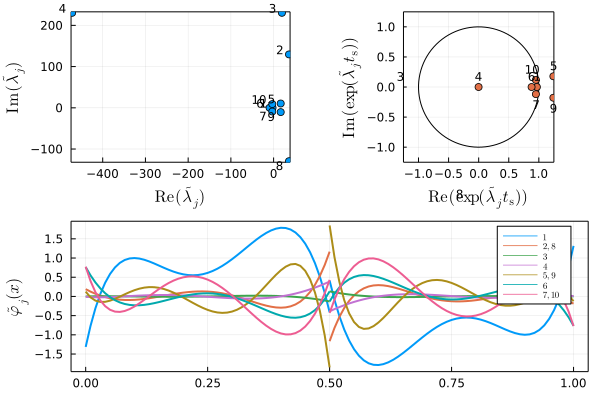

In [55]:
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)
dmd_results = analyze(dmd_analysis)
println("Max amplification:\n", findmax(abs.(dmd_results.σ)))
plot_analysis(dmd_analysis, dmd_results, i=1)

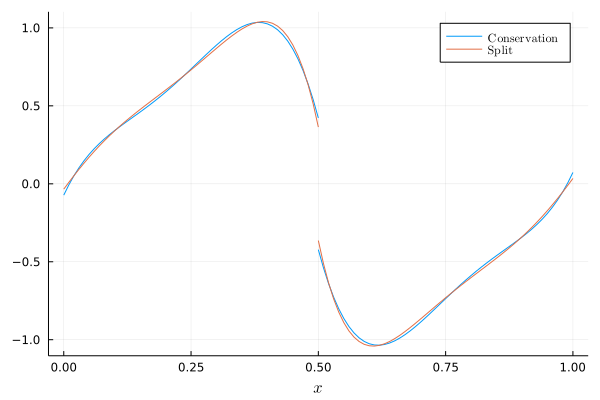

In [56]:
plotter = Plotter(spatial_discretization, "../results/burgers_conservation_vs_split/")
visualize([last(sol_cons.u), last(sol_split.u)], ["\\textrm{Conservation}", "\\textrm{Split}"],
    "numerical_solutions.pdf", plotter)